In [ ]:
!pip install tensorflow
!pip install keras
!pip install scipy
!pip install glob2

In [ ]:
from keras.preprocessing import image
from keras.models import load_model
from keras.applications.vgg16 import preprocess_input
import numpy as np
model=load_model('our_model.h5') #Loading our model
img=image.load_img('/content/chest_xray/test/PNEUMONIA/person100_bacteria_480.jpeg',target_size=(224,224))
imagee=image.img_to_array(img) #Converting the X-Ray into pixels
imagee=np.expand_dims(imagee, axis=0)
img_data=preprocess_input(imagee)
prediction=model.predict(img_data)
if prediction[0][0]>prediction[0][1]:  #Printing the prediction of model.
    print('Person is safe.')
else:
    print('Person is affected with Pneumonia.')
print(f'Predictions: {prediction}')


In [57]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import os
import shutil

def remove_ipynb_checkpoints(directory):
    for root, dirs, files in os.walk(directory):
        for dir_name in dirs:
            if dir_name == '.ipynb_checkpoints':
                shutil.rmtree(os.path.join(root, dir_name))

# Clean up the training and validation directories
remove_ipynb_checkpoints('chest_xray/train')
remove_ipynb_checkpoints('chest_xray/test')


# Load the pre-trained VGG16 model, excluding the top fully connected layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of the base model to prevent them from being trained
for layer in base_model.layers:
    layer.trainable = False

# Build the model using Functional API
inputs = tf.keras.Input(shape=(224, 224, 3))  # Input layer
x = base_model(inputs, training=False)        # Pass inputs through the pre-trained base model
x = Flatten()(x)                              # Flatten the output from the base model
x = Dense(256, activation='relu')(x)          # Add a dense layer with 256 units and ReLU activation
x = Dropout(0.5)(x)                           # Add dropout to prevent overfitting
outputs = Dense(1, activation='sigmoid')(x)   # Output layer with 3 units for multi-class classification (NORMAL, BACTERIAL PNEUMONIA, VIRAL PNEUMONIA)

# Define the model
model = tf.keras.Model(inputs, outputs)


# Compile the model with binary_crossentropy for 2-class classification
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])


# Model summary to verify the architecture
model.summary()

# Early stopping to prevent overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Checkpoint to save the best model
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)

# Prepare data generators (assuming you have training_set and validation_set)
train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

# Training and validation sets with binary class mode
training_set = train_datagen.flow_from_directory('chest_xray/train',
                                                 target_size=(224, 224),
                                                 batch_size=32,
                                                 class_mode='binary')  # binary class_mode

validation_set = test_datagen.flow_from_directory('chest_xray/test',
                                                  target_size=(224, 224),
                                                  batch_size=32,
                                                  class_mode='binary')  # binary class_mode


# Train the model
history = model.fit(training_set,
                    epochs=20,
                    validation_data=validation_set,
                    callbacks=[early_stop, checkpoint])

# Save the final model
model.save('final_model.h5')


Model: "functional_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_25 (InputLayer)          │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ vgg16 (Functional)                   │ (None, 7, 7, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_11 (Flatten)                 │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ (None, 256)                 │       6,422,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,137,729 (80.63 MB)

 Trainable params: 6,423,041 (24.50 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

Found 97 images belonging to 2 classes.

Found 286 images belonging to 2 classes.

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.

  self._warn_if_super_not_called()


4/4 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.4545 - loss: 0.8722 - val_accuracy: 0.8287 - val_loss: 0.5115

Epoch 2/20

4/4 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.5942 - loss: 0.6108 - val_accuracy: 0.2867 - val_loss: 0.8343

Epoch 3/20

4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.7533 - loss: 0.5584 - val_accuracy: 0.1818 - val_loss: 1.4072

Epoch 4/20

4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.7174 - loss: 0.5421 - val_accuracy: 0.3042 - val_loss: 0.9391

Epoch 5/20

4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.8036 - loss: 0.3894 - val_accuracy: 0.8531 - val_loss: 0.4072

Epoch 6/20

4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - accuracy: 0.8386 - loss: 0.4105 - val_accuracy: 0.8671 - val_loss: 0.3363

Epoch 7/20

4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.7930 - loss: 0.4416 - val_accuracy: 0.8112 - val_loss: 0.4715

Epoch 8/20

4/4 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.6904 - loss: 0.4092 - val_accuracy: 0.8252 - val_loss: 0.4437

Epoch 9/2

In [53]:
# Check the class labels used by the model
class_labels = training_set.class_indices
# This gives you a dictionary mapping class names to their corresponding indices
print("Class labels and their corresponding indices:", class_labels)

# If you want to extract just the class names, you can use:
class_names = list(class_labels.keys())
print("Class names:", class_names)


Class labels and their corresponding indices: {'NORMAL': 0, 'PNEUMONIA': 1}

Class names: ['NORMAL', 'PNEUMONIA']


In [54]:
# Get training and validation accuracy
training_accuracy = history.history['accuracy'][-1]  # Accuracy after the last epoch
validation_accuracy = history.history['val_accuracy'][-1]  # Validation accuracy after the last epoch

# Print the accuracy
print(f"Training Accuracy: {training_accuracy * 100:.2f}%")
print(f"Validation Accuracy: {validation_accuracy * 100:.2f}%")


Training Accuracy: 91.75%

Validation Accuracy: 85.66%


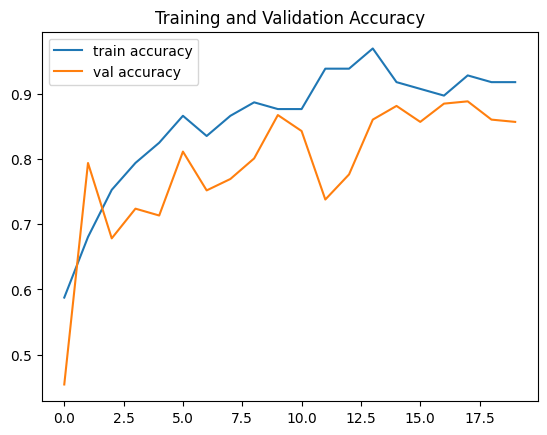

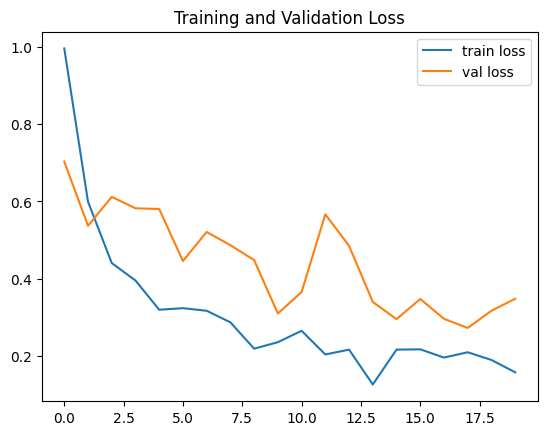

In [55]:
# Plot training and validation loss and accuracy
import matplotlib.pyplot as plt

# Accuracy plot
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

# Loss plot
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

In [60]:
!pip install gradio

In [63]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Building a simple CNN model from scratch
model = Sequential()

# Convolutional layer 1
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Convolutional layer 2
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Convolutional layer 3
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten the output for fully connected layers
model.add(Flatten())

# Fully connected layer 1
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))

# Output layer with 2 units for binary classification
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Model summary
model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_13 (Flatten)                 │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_26 (Dense)                     │ (None, 256)                 │      22,151,424 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_27 (Dense)                     │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 22,244,929 (84.86 MB)

 Trainable params: 22,244,929 (84.86 MB)

 Non-trainable params: 0 (0.00 B)

In [64]:
# Train the custom model
history = model.fit(training_set,
                    epochs=20,
                    validation_data=validation_set,
                    callbacks=[early_stop, checkpoint])


Epoch 1/20

4/4 ━━━━━━━━━━━━━━━━━━━━ 18s 3s/step - accuracy: 0.5829 - loss: 0.7298 - val_accuracy: 0.1818 - val_loss: 0.7576

Epoch 2/20

4/4 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.6046 - loss: 0.6884 - val_accuracy: 0.1818 - val_loss: 0.7751

Epoch 3/20

4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.6318 - loss: 0.6588 - val_accuracy: 0.1818 - val_loss: 1.0696

Epoch 4/20

4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.5182 - loss: 0.7765 - val_accuracy: 0.1818 - val_loss: 0.8860

Epoch 5/20

4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.5986 - loss: 0.6656 - val_accuracy: 0.1818 - val_loss: 0.8313


In [70]:

from tensorflow import keras
from keras.layers import Input, Lambda, Dense, Flatten


In [72]:
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

In [75]:
IMAGE_SIZE = [224, 224]

train_path = 'chest_xray/train'
valid_path = 'chest_xray/test'

In [76]:
vgg = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)
for layer in vgg.layers:
    layer.trainable = False
folders = glob('chest_xray/train/*')
x = Flatten()(vgg.output)
prediction = Dense(len(folders), activation='softmax')(x)
# create a model object
model = Model(inputs=vgg.input, outputs=prediction)
# view the structure of the model
model.summary()

Model: "functional_65"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_28 (InputLayer)          │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_14 (Flatten)                 │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_28 (Dense)                     │ (None, 2)                   │          50,178 │
└──────────────────────────────────────┴─────────────────────────────┴──────────────

 Total params: 14,764,866 (56.32 MB)

 Trainable params: 50,178 (196.01 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [79]:
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)
test_datagen = ImageDataGenerator(rescale = 1./255)
training_set = train_datagen.flow_from_directory('chest_xray/train',
                                                 target_size = (224, 224),
                                                 batch_size = 10,
                                                 class_mode = 'categorical')
test_set = test_datagen.flow_from_directory('chest_xray/test',
                                            target_size = (224, 224),
                                            batch_size = 10,
                                            class_mode = 'categorical')

Found 97 images belonging to 2 classes.

Found 286 images belonging to 2 classes.


In [81]:
r = model.fit(
  training_set,
  validation_data=test_set,
  epochs=1,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)

10/10 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - accuracy: 0.5328 - loss: 1.1576 - val_accuracy: 0.1853 - val_loss: 2.1675


In [82]:
import tensorflow as tf
from keras.models import load_model
model.save('chest_xray.h5')

In [86]:
from keras.models import load_model
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
import numpy as np
model=load_model('final_model.h5')

In [87]:
img=image.load_img('/content/chest_xray/test/PNEUMONIA/person10_virus_35.jpeg',target_size=(224,224))
x=image.img_to_array(img)
x=np.expand_dims(x, axis=0)
img_data=preprocess_input(x)
classes=model.predict(img_data)
result=int(classes[0][0])
if result==0:
    print("Person is Affected By PNEUMONIA")
else:
    print("Result is Normal")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 553ms/step

Person is Affected By PNEUMONIA


In [89]:
import gradio as gr
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import load_model
from PIL import Image  # Ensure that you have the correct PIL import
model = load_model('final_model.h5')
class_labels = ['NORMAL', 'PNEUMONIA']
def classify_xray(img):
    if not isinstance(img, Image.Image):
        return "Invalid image format. Please upload a valid image."
    img = img.resize((224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    predictions = model.predict(img_array)
    predicted_class = class_labels[np.argmax(predictions)]
    return f"Predicted Class: {predicted_class}"
gradio_interface = gr.Interface(
    fn=classify_xray,
    inputs=gr.Image(type="pil"),  
    outputs="text",
    title="Pneumonia Detection from X-ray",
    description="Upload a chest X-ray image to classify it as Normal or Pneumonia."
)
gradio_interface.launch()

Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).



Colab notebook detected. To show errors in colab notebook, set debug=True in launch()

Running on public URL: https://3c005d99f717d87f26.gradio.live



This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
